In [543]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [544]:
import h5py

In [545]:
import tensorflow as tf

In [546]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [547]:
from uatu.watchers import *

In [548]:
from scipy.ndimage import rotate

In [549]:
def log_barrier(x_p, x_o, eps, lam):
    norm = tf.norm(x_p - x_o+1e-6)
    return -tf.log(eps - norm )/lam

In [550]:
def compute_attacked_map(model_init_fn, cost_fn, network_fname,\
                         x_np, target_y_np, n_steps = 10, training=False, adv = False,\
                        use_log_barrier = True, log_eps = 1.5):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, 256, 256,1])
    #y = tf.placeholder(tf.float32, [None,2])
    y = tf.placeholder(tf.float32, [None,2])
    #orig_norm  = tf.placeholder(tf.float32)
    x_orig = tf.placeholder(tf.float32, [None, 256, 256,1])

    log_barrier_weight = tf.placeholder(tf.float32)
    
    if adv:
        with tf.variable_scope('kappa_filters') as scope:
            preds = model_init_fn(x, training=training)

            loss = cost_fn(y, preds, x, model_init_fn, {'training':training, 'lam': 0.0}, scope)
    else:
        preds = model_init_fn(x, training=training)
        
        loss = cost_fn(y, preds)
        
    if use_log_barrier:
        barrier_loss = log_barrier(x, x_orig, log_eps, log_barrier_weight)
        loss = loss + barrier_loss
        
    grads = tf.gradients(loss, x)

    # learning rate maybe needed?
    dX = tf.divide(grads, tf.norm(grads))[0]

    #with tf.device('/cpu:0'):
    saver = tf.train.Saver()

    with tf.Session() as sess:
        saver.restore(sess, network_fname)
        key_dict = {}

        x_attacked_np = x_np.copy()
        
        step = 1e-3
        lam = 1e9
        lam_incr = 1.00001
        for i in xrange(n_steps):
            feed_dict = {x: x_attacked_np,y:target_y_np, x_orig: x_np, log_barrier_weight: lam }#, training: False}
            dX_np, loss_np, barrier_loss_np = sess.run([dX, loss, barrier_loss], feed_dict=feed_dict)#[0][0]
            #print barrier_loss_np
            x_attacked_np-=step*rotate(dX_np.squeeze(), 0).reshape((1, 256, 256, 1))
            
            #if i%100 == 0:
            #    print np.linalg.norm(x_attacked_np - x_np), loss_np
            #    plt.imshow( (x_attacked_np - x_np).squeeze() )
            #    plt.title(i)
            #    plt.show()
            
            lam*=lam_incr
            if lam >= 1e9:
                lam = 1e9
            
        # ensure the attacked map has the same normalization as the old one.

    return x_attacked_np

In [551]:
def test(model_init_fn, x_np, fname,  n_samples = 10, training=False, adv = False):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, 256,256,1], name = 'x')

    if adv:
        with tf.variable_scope('kappa_filters') as scope:
            preds = model_init_fn(x, training=training)
    else:
        preds = model_init_fn(x, training=training)
        
    #with tf.device('/cpu:0'):
    saver = tf.train.Saver()

    with tf.Session() as sess:
        saver.restore(sess, fname)

        #assert y_np.shape[0] == 1 , 'batchsize greater than 1'
        samples = []
        feed_dict = {x: x_np}#, training: False}

        for j in xrange(n_samples):
            preds_np  = sess.run(preds, feed_dict=feed_dict)
            samples.append(preds_np)

    return np.vstack(samples)

In [552]:
f = h5py.File('../data/UatuLightconeTraining.hdf5', 'r')
mean, std =  f.attrs['mean'], f.attrs['std']
f.close()

In [553]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [554]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [555]:
n = 100 
batch_size = 1 

X = test_X[n, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#X = (X-mean)/(std)
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [556]:
targ_X = target_X[n, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#targ_X = (targ_X-mean)/(std)

In [557]:
n_steps = 100

In [558]:
net = 'bayes'
network_fname = '../networks/gupta_bayes_net_kappa-45000'
model_init_fn = gupta_bayesian_network_init_fn
cost_fn = original_bayes_cost_fn
training=True
adv = False

In [559]:
X_attacked = compute_attacked_map(model_init_fn, cost_fn, network_fname,\
                            X, target_Y, n_steps = n_steps, training=training, adv=adv, use_log_barrier = True)

In [560]:
true_samples = test(model_init_fn, X, network_fname,  100, training, adv=adv)
attacked_samples = test(model_init_fn, X_attacked, network_fname,  100, training, adv=adv)

In [561]:
true_samples[:,0].mean(),attacked_samples[:,0].mean()

(0.28540835, 0.31084624)

(0.2, 0.4)

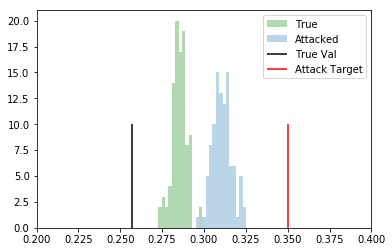

In [562]:
bins = np.linspace(0.2, 0.4, 100)
plt.hist(true_samples[:, 0], density=False, color = 'g', alpha = 0.3, label = "True", bins = bins);
plt.hist(attacked_samples[:, 0], density=False, alpha = 0.3, label = 'Attacked', bins = bins);
plt.vlines(Y[0, 0], 0, 10, label = 'True Val');
plt.vlines(target_Y[0,0], 0, 10, color = 'r', label = 'Attack Target');
plt.legend(loc='best')
plt.xlim([0.2, 0.4])

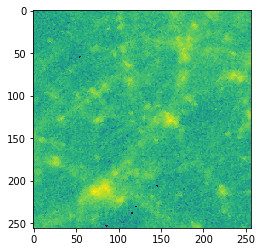

In [563]:
plt.imshow(X[0,:,:,0])

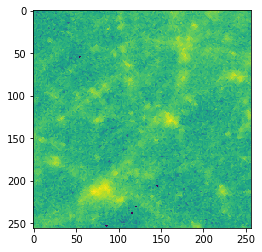

In [564]:
plt.imshow(X_attacked[0,:,:,0])

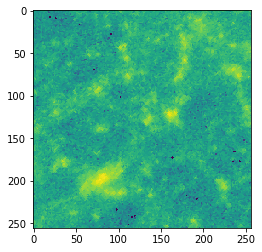

In [565]:
plt.imshow(targ_X[0,:,:,0])

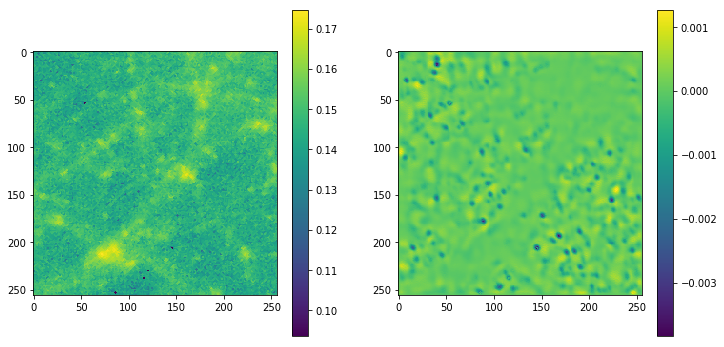

In [566]:
diff = X[0,:,:,0] - X_attacked[0,:,:,0]
fig = plt.figure(figsize = (12, 6))
plt.subplot(121)
im = plt.imshow(X.squeeze())
plt.colorbar(im)
plt.subplot(122)
im = plt.imshow(-diff)
plt.colorbar(im)

In [567]:
np.linalg.norm(-diff)

0.06455528004140665

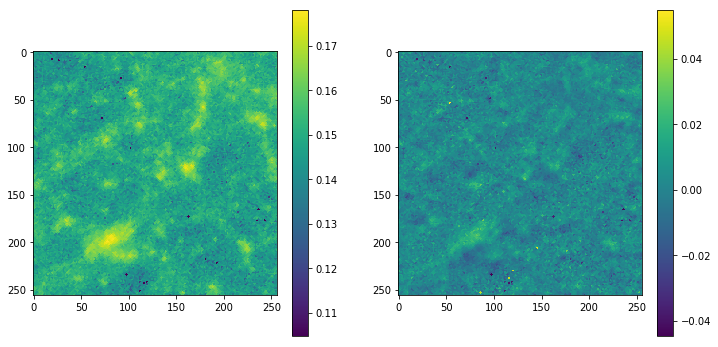

In [568]:
diff = targ_X[0,:,:,0] - X[0,:,:,0]
fig = plt.figure(figsize = (12, 6))
plt.subplot(121)
im = plt.imshow(targ_X[0,:,:,0].squeeze())
plt.colorbar(im)
plt.subplot(122)
im = plt.imshow(diff)
plt.colorbar(im)

In [569]:
np.linalg.norm(diff)

1.7865802507715278

In [570]:
attacked_ps = image_ps(X_attacked.squeeze())
target_ps = image_ps(targ_X.squeeze())
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_attacked- X).squeeze())

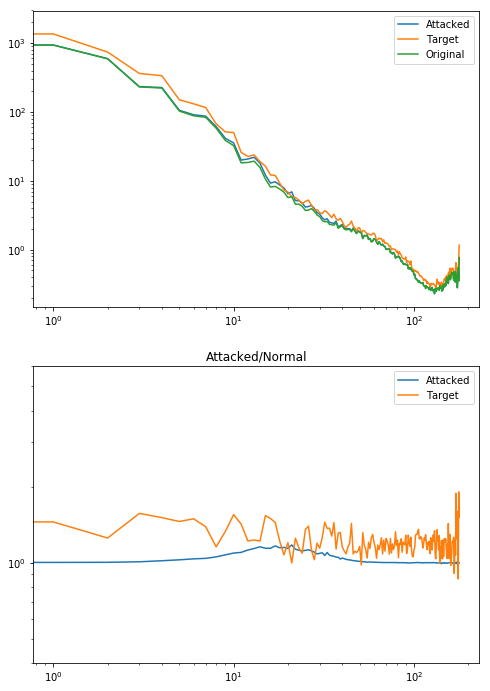

In [571]:
fig = plt.figure(figsize = (8, 12))
plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
plt.subplot(212)
plt.title("Attacked/Normal")
plt.plot(attacked_ps/normal_ps, label = 'Attacked')
plt.plot(target_ps/normal_ps, label = 'Target')
plt.legend(loc='best')
plt.ylim([0.4, 6])
plt.loglog();

---

In [414]:
from scipy.fftpack import fft2

In [415]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [416]:
from scipy import fftpack
import numpy as np
import pylab as py
#import radialProfile

def image_ps(image):
  
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)

    return psd1D

In [419]:
attacked_ps = np.zeros((target_X.shape[0], 179))
normal_ps = np.zeros((target_X.shape[0], 179))
target_ps = np.zeros((target_X.shape[0], 179))
diff_ps = np.zeros((target_X.shape[0], 179))
diff2_ps = np.zeros((target_X.shape[0], 179))

n_samples = 10
true_samples_all = np.zeros((target_X.shape[0]*n_samples, 2))
attacked_samples_all = np.zeros_like(true_samples_all)


for n in range(target_X.shape[0]):
    print n,
    X_attacked = compute_attacked_map(model_init_fn, cost_fn, network_fname,\
                            test_X[n].reshape(1, X.shape[1], X.shape[2], X.shape[3])\
                        , target_Y, n_steps = n_steps, training=training, adv = adv)
    
    true_samples_all[n*n_samples:(n+1)*n_samples] = test(model_init_fn, test_X[n].reshape(1, X.shape[1], X.shape[2], X.shape[3]), \
                                                         network_fname,  n_samples, training, adv=adv)
    attacked_samples_all[n*n_samples:(n+1)*n_samples] = test(model_init_fn, X_attacked, network_fname,  n_samples, training, adv=adv)
    
    attacked_ps[n] = image_ps(X_attacked.squeeze())
    target_ps[n] = image_ps(target_X[n].squeeze())

    normal_ps[n] = image_ps(test_X[n].squeeze())
    diff_ps[n] = image_ps( (X_attacked - test_X[n]).squeeze())
    diff2_ps[n] = image_ps( (X_attacked - target_X[n]).squeeze())

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

KeyboardInterrupt: 

In [ ]:
attacked_ps.shape

In [ ]:
fig = plt.figure(figsize = (8, 12))
plt.subplot(211)
plt.errorbar(range(179), attacked_ps.mean(axis = 0), yerr=attacked_ps.std(axis=0) )
plt.errorbar(range(179), normal_ps.mean(axis = 0), yerr = normal_ps.std(axis=0))
plt.errorbar(range(179), diff_ps.mean(axis = 0), yerr = diff_ps.std(axis=0))
plt.legend(loc='best')
plt.loglog();
plt.subplot(212)
plt.title("Attacked/Normal")
plt.plot(attacked_ps.mean(axis=0)/normal_ps.mean(axis=0))
plt.ylim([0.4, 6])
plt.loglog()

In [ ]:
fig = plt.figure(figsize = (8, 12))
plt.subplot(211)
plt.errorbar(range(179), attacked_ps.mean(axis = 0), yerr=attacked_ps.std(axis=0), label = 'Attacked' )
plt.errorbar(range(179), target_ps.mean(axis = 0), yerr = target_ps.std(axis=0), label = 'Target')
plt.errorbar(range(179), normal_ps.mean(axis = 0), yerr = normal_ps.std(axis=0), label = 'Original')
plt.legend(loc='best')
plt.loglog();
plt.subplot(212)
plt.title("Attacked/Normal")
plt.plot(attacked_ps.mean(axis=0)/normal_ps.mean(axis=0))
plt.plot(target_ps.mean(axis=0)/normal_ps.mean(axis=0))

plt.ylim([0.4, 6])
plt.loglog()

In [ ]:
fig = plt.figure(figsize = (8, 12))
plt.subplot(211)
plt.plot(attacked_ps.mean(axis = 0), label = 'Attacked' )
plt.plot(target_ps.mean(axis = 0), label = 'Target')
plt.plot(normal_ps.mean(axis = 0), label = 'Original')
plt.legend(loc='best')
plt.loglog();
plt.subplot(212)
plt.title("Attacked/Normal")
plt.plot(attacked_ps.mean(axis=0)/normal_ps.mean(axis=0), label = 'Attacked')
plt.plot(target_ps.mean(axis=0)/normal_ps.mean(axis=0), label = 'Target')
plt.legend(loc='best')
plt.ylim([0.4, 6])
plt.loglog()

In [ ]:
ty = target_boxno
np.savetxt('attacked_ps_boxno_%d_ty_%d_net_%s.npy'%(boxno, ty, net), attacked_ps)
np.savetxt('normal_ps_boxno_%d_ty_%d_net_%s.npy'%(boxno, ty, net), normal_ps)
np.savetxt('diff_ps_boxno_%d_ty_%d_net_%s.npy'%(boxno, ty, net), diff_ps)
np.savetxt('target_ps_boxno_%d_ty_%d_net_%s.npy'%(boxno, ty, net), target_ps)

In [ ]:
%%bash
ls attacked*.npy -ltr